# **Data Visualization**

## Objectives

- Answer business requirement 1:
    -  The client requires a visual study ro differentiata mildew-affected leaves from healthy ones.

## Inputs

- inputs/cherry_leaves_dataset/cherry-leaves/train
- inputs/cherry_leaves_dataset/cherry-leaves/test
- inputs/cherry_leaves_dataset/cherry-leaves/validation

## Outputs

- Image shape embeddings pickle file.
- Mean and variability of images per label plot.
- Plot to distinguish the contrast between mildew-affected and healthy leaves.
- Code to build an image montage on the Streamlit dashboard.

## Additional Comments

- No additional comments.

---

# Setup

## Import libraries

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing import image

sns.set_style("white")

## Set working directory

In [7]:
cwd = os.getcwd()
os.chdir('/workspace/pp5_cherry_leaves_mildew_detection')
work_dir = os.getcwd()
print("New working directory set:", work_dir)

New working directory set: /workspace/pp5_cherry_leaves_mildew_detection


### Set Input Directories

In [8]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

### Set Output Directory

In [9]:
version = 'v1'
file_path = f'outputs/{version}'

if not os.path.exists(file_path):
    os.makedirs(file_path)

### Set Label Names

In [10]:
labels = os.listdir(train_path)
print('Image labels are:', labels)

Image labels are: ['healthy', 'powdery_mildew']


## Image Dimentions

### Comute average image dimentions for the train set

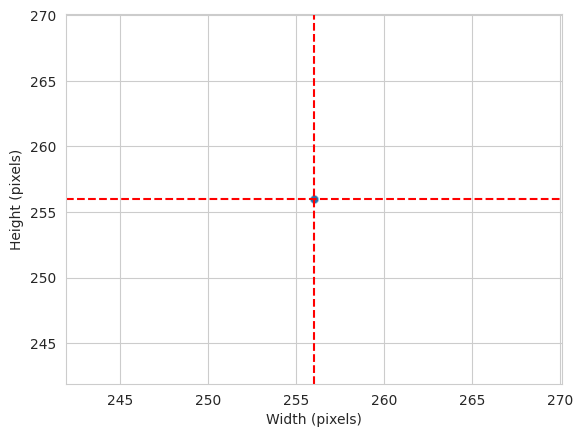

Average Width: 256, Average Height: 256


In [11]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(os.path.join(train_path, label)):
        img = imread(os.path.join(train_path, label, image_filename))
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)

sns.set_style("whitegrid")
fig, ax = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
ax.set_xlabel("Width (pixels)")
ax.set_ylabel("Height (pixels)")

dim1_mean = int(np.mean(dim1))
dim2_mean = int(np.mean(dim2))
ax.axvline(x=dim2_mean, color='r', linestyle='--')
ax.axhline(y=dim1_mean, color='r', linestyle='--')
plt.show()

print(f"Average Width: {dim2_mean}, Average Height: {dim1_mean}")


### Load Images and Labels as Arrays without Resizing

In [12]:
def load_image_as_array(data_dir, n_images_per_label=20):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    
    for label in labels:
        counter = 0
        for img_name in os.listdir(os.path.join(data_dir, label)):
            if counter < n_images_per_label:
                img = imread(os.path.join(data_dir, label, img_name)) / 255
                X = np.append(X, img).reshape(-1, dim1_mean, dim2_mean, 3)
                y = np.append(y, label)
                counter += 1
    return X, y

### Load Images and Labels for the Train Set

In [13]:
X, y = load_image_as_array(train_path, n_images_per_label=30)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")


Data shape: (60, 256, 256, 3), Labels shape: (60,)


### Plot Mean and Variability pro Label

In [14]:
def plot_mean_variability_per_label(X, y, figsize=(12, 5), save_image=False):
    for label in np.unique(y):
        sns.set_style("white")
        mask = (y == label).reshape(-1)
        arr = X[mask]
        
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(avg_img)
    axes[0].set_title(f"Mean Image for {label}")
    axes[1].imshow(std_img)
    axes[1].set_title(f"Variability for {label}")

    if save_image:
        plt.savefig(f"{file_path}/mean_variability_{label}.png", dpi=150)
    plt.show()

### Plot and save the Mean and Variability Images

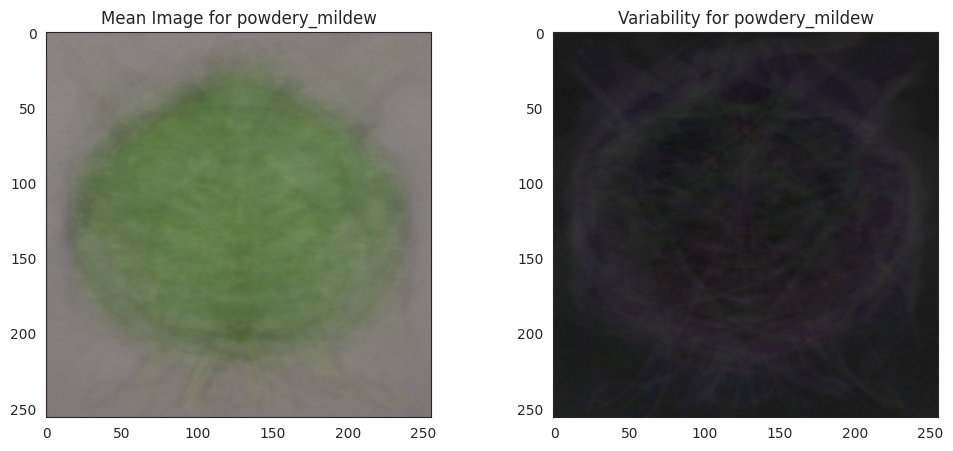

In [15]:
plot_mean_variability_per_label(X, y, save_image=True)

---

## Difference Between Average Images of Healthy and Mildew-Affected Leaves

### Define function to subset images by label

In [16]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    return X[boolean_mask]

### Define function to calculate and display differences between average images of two labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


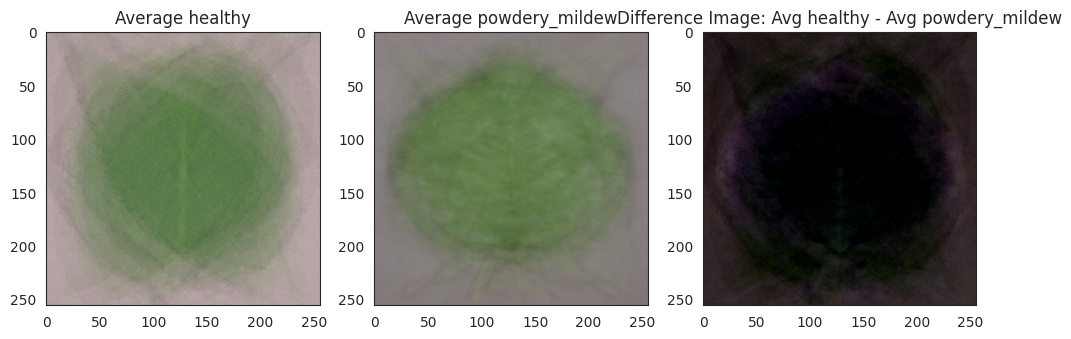

In [20]:
def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} is not found in {np.unique(y)}")
        return

    # Calculate mean image for label_1
    images_label1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label1, axis=0)

    # Calculate mean image for label_2
    images_label2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label2, axis=0)

    # Calculate difference and plot difference along with avg images of both labels
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg)
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg)
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean)
    axes[2].set_title(f'Difference Image: Avg {label_1} - Avg {label_2}')

    if save_image:
        plt.savefig(f"{file_path}/avg_diff_{label_1}_{label_2}.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()
diff_bet_avg_image_labels_data_as_array(X=X, y=y, label_1='healthy', label_2='powdery_mildew', figsize=(12, 10), save_image=True)

## Image Montage for Healthy and Mildew-Affected Leaves

In [21]:
import itertools
import random
sns.set_style("white")

### Define function to create an image montage for a specific label

Montage for healthy


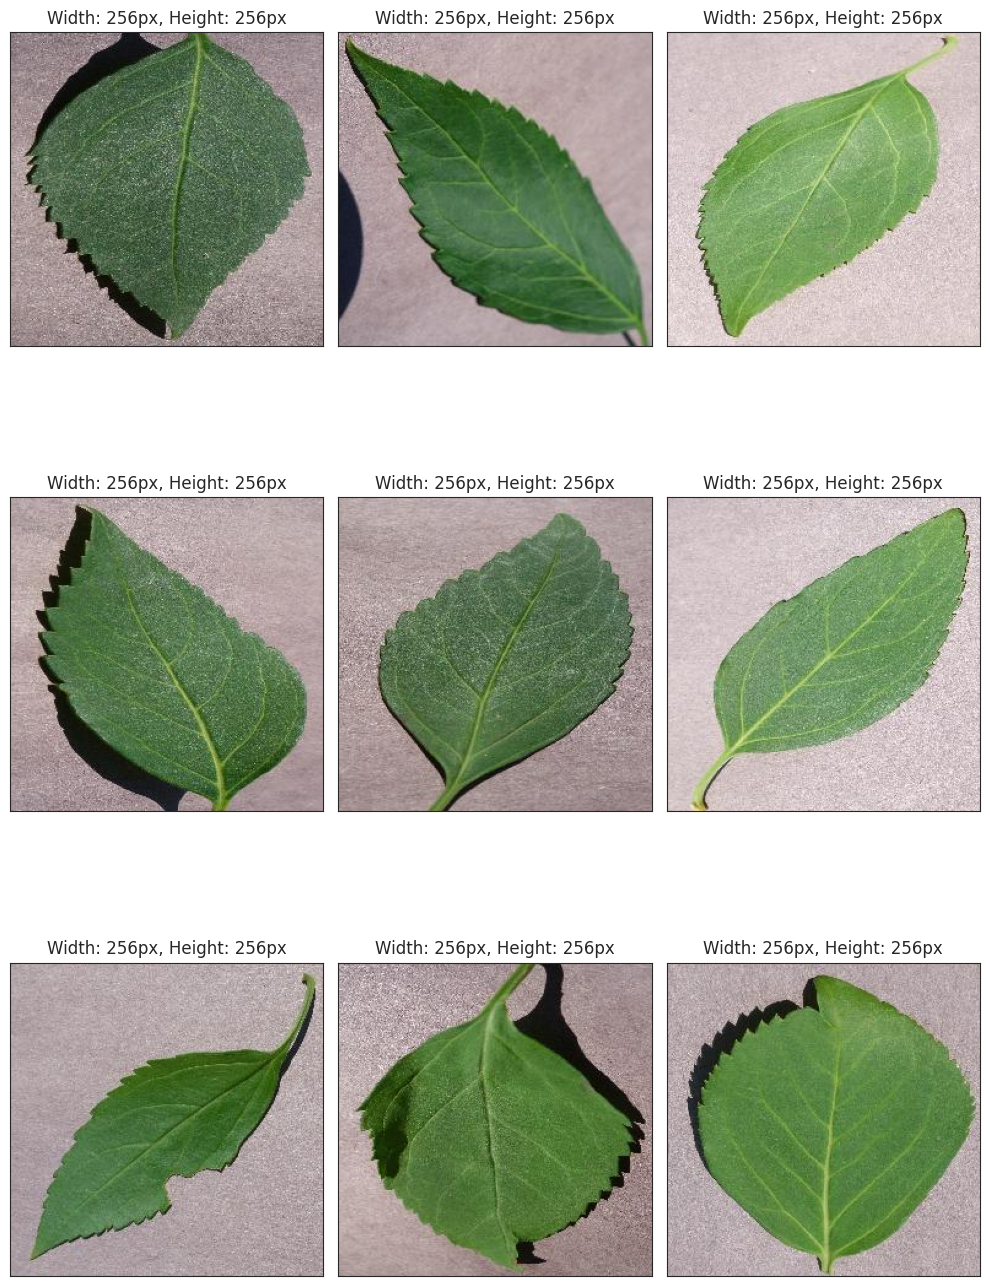



Montage for powdery_mildew


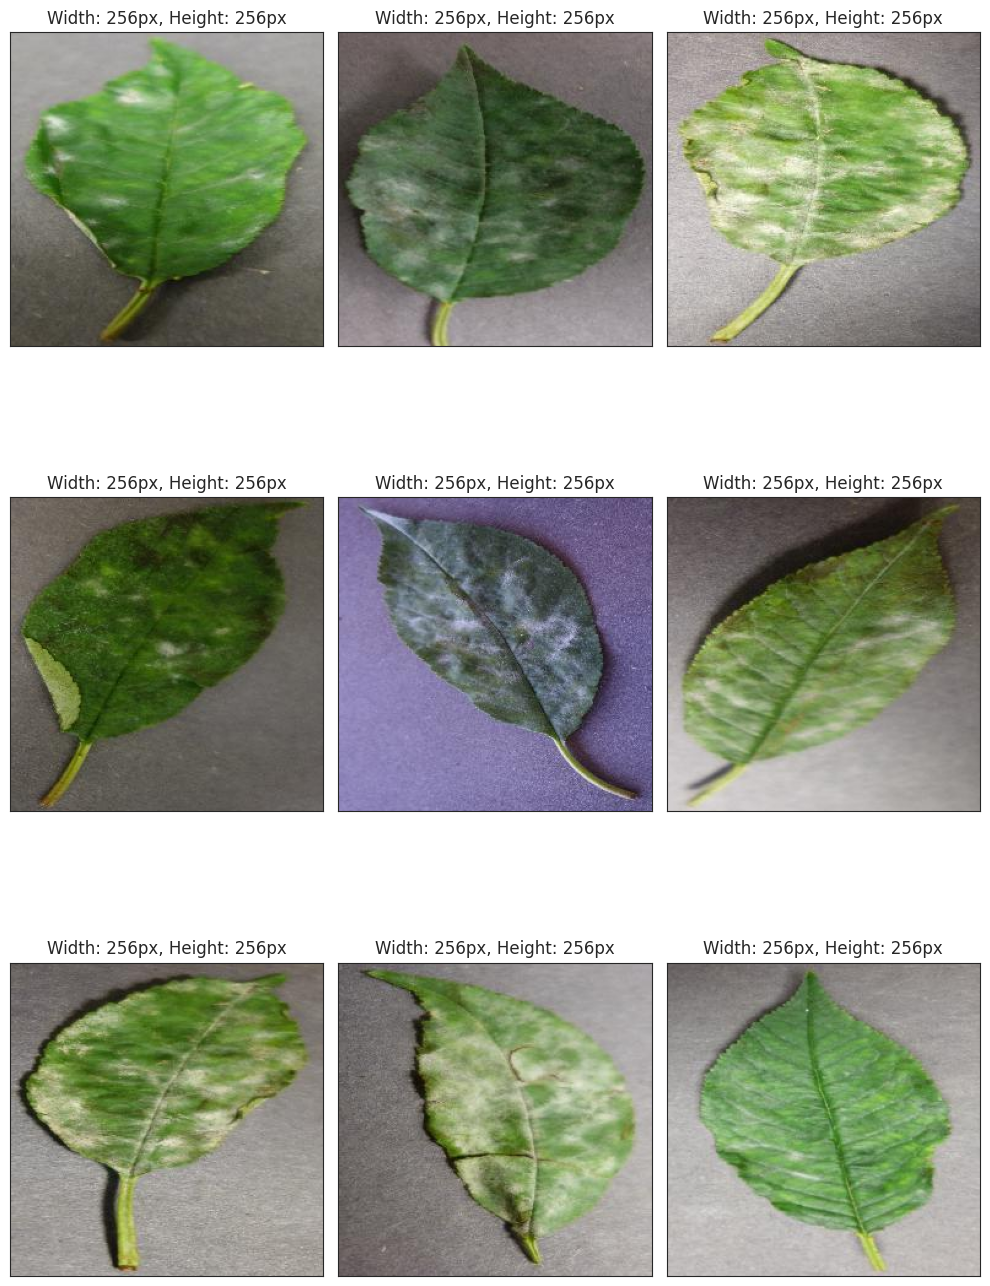

In [22]:
def image_montage(dir_path, label_to_display, nrows=3, ncols=3, figsize=(15, 10)):
    labels = os.listdir(dir_path)

    # Check if the specified label exists in the directory
    if label_to_display in labels:
        images_list = os.listdir(os.path.join(dir_path, label_to_display))
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(f"Reduce nrows or ncols for the montage. There are {len(images_list)} images, and the requested montage space is {nrows * ncols}")
            return

        # Create grid of image positions
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # Display the montage of images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for i, img_name in enumerate(img_idx):
            img = imread(os.path.join(dir_path, label_to_display, img_name))
            img_shape = img.shape
            ax = axes[plot_idx[i][0], plot_idx[i][1]]
            ax.imshow(img)
            ax.set_title(f"Width: {img_shape[1]}px, Height: {img_shape[0]}px")
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print("The specified label does not exist.")
        print(f"Available labels are: {labels}")

# Run image montage for each label
for label in labels:
    print(f"Montage for {label}")
    image_montage(dir_path=train_path, label_to_display=label, nrows=3, ncols=3, figsize=(10, 15))
    print("\n")